**KQ general housekeeping notes**: I'm assuming the updated version is the final version, but in the future make sure you only have one version. The benefits of GitHub are that you have version control built in. Also, make sure you delete all of your local branches once you merge into the master branch. Your repo has a bunch of 'stale' branches, which are no longer active or in sync with the master, which could create issues if you create a branch that already is on the remote (i.e., what you see on the website) when you push changes from your local machine! 

## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [4]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# sklearn for prediction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

import multiprocessing
from tqdm import tqdm

# gensim
import gensim
from gensim import models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# EDA
import re
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import scattertext as st

import pickle

In [5]:
congress_tweets = pd.read_csv("116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(n=10000, random_state=1).reset_index(drop=True)
#congress_tweets.head()

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [6]:
#remove missing values/reset index
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)
congress_tweets['text_original'] = congress_tweets['text']
#congress_tweets.head()

In [7]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words.add("rt")
    nlp.Defaults.stop_words.add("qt")
    nlp.Defaults.stop_words.add("amp")
    nlp.Defaults.stop_words.add("RT")
    nlp.Defaults.stop_words.add("QT")
    
    punc = set(punctuation)
    more_stop = {'\n\n ','\n ','\n','—','“','”','\n\n','–'}
    punc = punc.union(more_stop)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
            
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [8]:
#deal with URLS
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+'"")
    return url_pattern.sub(r'', text)

congress_tweets['text'] = congress_tweets['text'].apply(remove_urls)

In [6]:
#deal with emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                            u"\u200d"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

congress_tweets['text'] = congress_tweets['text'].apply(remove_emoji)

In [11]:
def remove_letters(text):

    shortword = re.compile(r'\W*\b\w{1,1}\b')
    return shortword.sub('', text)

congress_tweets['text'] = congress_tweets['text'].apply(remove_letters)

In [7]:
#tokenization
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
#the line of code below disrupts some EDA, so not running it yet and leaving the tokens without merging
#congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
#congress_tweets['tokens']

In [8]:
#Change Independent Senators who caucus with Democrats to party==Democrat
congress_tweets.loc[congress_tweets.party == "Independent", "party"] = "Democrat"

In [14]:
# Run this line to save your pre-processed data so that you don't have to keep re-running it every time you work on the notebook
#congress_tweets.to_csv('congress_tweets_preprocessed.csv')

In [9]:
# Run this line to read back in your saved pre-processed data rather than re-running the lines above
congress_tweets = pd.read_csv('congress_tweets_preprocessed.csv')

**KQ**: nice preprocessing. You can also add stop words in a list rather than one by one. Refer to class notebooks for how to do this 

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: Topic Modeling

In [4]:
X = congress_tweets['text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X.values.astype('U'))
dense_matrix = tfidf_matrix.todense()

In [5]:
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [6]:
lda2 = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=0)
lda2 = lda2.fit(dense_matrix)

In [7]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [8]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
mask   preexisting distancing wear apply postal visit art enrollment learn protectourcare hands stay covid19 wearing congressional social join practice

Topic #1:
president impeachment trump   mueller investigation inquiry foreign ukraine schiff report russia election evidence realdonaldtrump witnesses barr white political biden

Topic #2:
de la en el para que los del por las miners su se con ¡ bringbackourgirls congrats un más al

Topic #3:
  today act need health people work help house trump time covid19 american new thank bill americans congress president support

Topic #4:
nan cancer hanukkah celebrating rushing happy huawei ginsburg minimum msnbc devos flu nitalowey ruth hoping body joy betsy raisethewage gutted



In [9]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda2, tf_feature_names, 20)


Topic #0:
enrollment getcovered   committed michigan works enroll virginia stem signs deadline easier arkansas depend 15th promised scam nov indian birthday

Topic #1:
barrett amy coney attorney william committed childcare refuge sen congratulations principles foundation afghanistan alexander listen arctic ruled trump repmarkmeadows ross

Topic #2:
floyd de voters mark holocaust beneficiaries cool reflect situation green unique murdered bigotry en tide banking remembrance helpful potential dignity

Topic #3:
  today trump president people health need act house work covid19 help time american congress new thank americans support bill

Topic #4:
hanukkah celebrating blessed lewis repcummings weekly philly fridayswithfrank cummings happy john join update elijah gopoversight   risen michigan sameach restorethevote

Topic #5:
nan daca schiff recipients planet adam dreamers father actonclimate memorialday protectthedream blood earthday tps michaelcburgess tirelessly moved repkevinbrady guns

#### Neither of the topic groups seem intuitively distinguishing between parties or positions within congress; now let's see if the distribution of the topics vary across party/position groups.

In [10]:
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.03837111, 0.03861981, 0.03834846, 0.8462159 , 0.03844472],
       [0.21187482, 0.04900972, 0.0488534 , 0.64139821, 0.04886385],
       [0.0366255 , 0.03682384, 0.03654917, 0.64176009, 0.24824141],
       ...,
       [0.0455092 , 0.04533956, 0.04533111, 0.81848852, 0.0453316 ],
       [0.0455907 , 0.04564027, 0.04561042, 0.8175649 , 0.04559371],
       [0.04333136, 0.04308156, 0.0431387 , 0.30989037, 0.56055801]])

In [11]:
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(congress_tweets)
df_w_topics.head()

,0,1,2,3,4,Unnamed: 0,index,tweet_id,screen_name,datetime,...,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_original,tokens
0,0.038371,0.038620,0.038348,0.846216,0.038445,0,0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,...,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",Thank you for testifying today Mr. Blake. http...,"['Thank', 'testifying', 'today', 'Mr', 'Blake'..."
1,0.211875,0.049010,0.048853,0.641398,0.048864,1,1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,...,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688",My Twitter Town Hall on healthcare has begun a...,"['My', 'Twitter', 'Town', 'Hall', 'healthcare'..."
2,0.036625,0.036824,0.036549,0.641760,0.248241,2,2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,...,M,AR,2,Republican,"684,872","380,494","394,409","647,744",Scipio Jones‘ fight for civil rights and equal...,"['Scipio', 'Jones', '‘', 'fight', 'civil', 'ri..."
3,0.047192,0.047236,0.047187,0.811198,0.047188,3,3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,...,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",There is no better time to #ActOnClimate than ...,"['There', 'better', 'time', 'ActOnClimate', 'E..."
4,0.041928,0.041941,0.041897,0.832337,0.041898,4,4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,...,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958",I understand the VA often has problems recruit...,"[' ', 'understand', 'VA', 'problems', 'recruit..."


In [12]:
grouped = df_w_topics.groupby('position')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

position
Rep    0.096099
Sen    0.083279
Name: 0, dtype: float64
position
Rep    0.108783
Sen    0.103103
Name: 1, dtype: float64
position
Rep    0.079770
Sen    0.070526
Name: 2, dtype: float64
position
Sen    0.675107
Rep    0.649564
Name: 3, dtype: float64
position
Sen    0.067985
Rep    0.065785
Name: 4, dtype: float64


#### There doesn't seem any difference between positions indicated by these 5 topics.

In [13]:
topic_dist2 = lda2.transform(tfidf_matrix)
topic_dist2

array([[0.0191599 , 0.01916002, 0.0191605 , ..., 0.01916764, 0.01916221,
        0.01918272],
       [0.0244162 , 0.02441569, 0.02441569, ..., 0.02441575, 0.02441586,
        0.0244157 ],
       [0.01814078, 0.01814058, 0.01813878, ..., 0.01813832, 0.01813796,
        0.01813796],
       ...,
       [0.1787389 , 0.02266183, 0.10858311, ..., 0.02265782, 0.0226581 ,
        0.02265777],
       [0.0227889 , 0.02280943, 0.02279287, ..., 0.0227889 , 0.02278905,
        0.0227889 ],
       [0.02144765, 0.02144681, 0.02144689, ..., 0.02144822, 0.02144775,
        0.02144681]])

In [14]:
topic_dist_df2 = pd.DataFrame(topic_dist2)
df_w_topics2 = topic_dist_df2.join(congress_tweets)
df_w_topics2.head()

,0,1,2,3,4,5,6,7,8,9,...,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_original,tokens
0,0.019160,0.019160,0.019160,0.595459,0.251228,0.019160,0.019160,0.019168,0.019162,0.019183,...,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",Thank you for testifying today Mr. Blake. http...,"['Thank', 'testifying', 'today', 'Mr', 'Blake'..."
1,0.024416,0.024416,0.024416,0.672506,0.024422,0.024416,0.132162,0.024416,0.024416,0.024416,...,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688",My Twitter Town Hall on healthcare has begun a...,"['My', 'Twitter', 'Town', 'Hall', 'healthcare'..."
2,0.018141,0.018141,0.018139,0.594299,0.260590,0.018139,0.018138,0.018138,0.018138,0.018138,...,M,AR,2,Republican,"684,872","380,494","394,409","647,744",Scipio Jones‘ fight for civil rights and equal...,"['Scipio', 'Jones', '‘', 'fight', 'civil', 'ri..."
3,0.023590,0.023591,0.023590,0.524960,0.023593,0.286313,0.023591,0.023592,0.023590,0.023590,...,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",There is no better time to #ActOnClimate than ...,"['There', 'better', 'time', 'ActOnClimate', 'E..."
4,0.020940,0.020940,0.020940,0.811541,0.020940,0.020940,0.020940,0.020940,0.020940,0.020940,...,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958",I understand the VA often has problems recruit...,"[' ', 'understand', 'VA', 'problems', 'recruit..."


In [15]:
grouped = df_w_topics2.groupby('position')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

position
Sen    0.054681
Rep    0.051732
Name: 0, dtype: float64
position
Sen    0.050068
Rep    0.048713
Name: 1, dtype: float64
position
Rep    0.048264
Sen    0.046706
Name: 2, dtype: float64
position
Sen    0.571924
Rep    0.562318
Name: 3, dtype: float64
position
Rep    0.044583
Sen    0.041996
Name: 4, dtype: float64
position
Rep    0.050346
Sen    0.045045
Name: 5, dtype: float64
position
Rep    0.044527
Sen    0.041370
Name: 6, dtype: float64
position
Rep    0.056762
Sen    0.056499
Name: 7, dtype: float64
position
Sen    0.050567
Rep    0.045485
Name: 8, dtype: float64
position
Rep    0.047270
Sen    0.041145
Name: 9, dtype: float64


#### There doesn't seem any difference between positions indicated by the 10 topics, either. Now let's see if the topics are helpful in distinguishing between parties.

In [16]:
grouped = df_w_topics.groupby('party')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

party
Republican    0.093604
Democrat      0.092899
Name: 0, dtype: float64
party
Republican    0.118939
Democrat      0.101077
Name: 1, dtype: float64
party
Democrat      0.078762
Republican    0.075643
Name: 2, dtype: float64
party
Democrat      0.662781
Republican    0.642282
Name: 3, dtype: float64
party
Republican    0.069532
Democrat      0.064480
Name: 4, dtype: float64


In [17]:
grouped = df_w_topics2.groupby('party')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

party
Democrat      0.052897
Republican    0.051538
Name: 0, dtype: float64
party
Republican    0.052186
Democrat      0.047259
Name: 1, dtype: float64
party
Republican    0.048820
Democrat      0.047396
Name: 2, dtype: float64
party
Democrat      0.571357
Republican    0.552293
Name: 3, dtype: float64
party
Republican    0.046419
Democrat      0.042631
Name: 4, dtype: float64
party
Republican    0.051176
Democrat      0.047983
Name: 5, dtype: float64
party
Republican    0.048519
Democrat      0.041167
Name: 6, dtype: float64
party
Democrat      0.057442
Republican    0.055375
Name: 7, dtype: float64
party
Republican    0.049004
Democrat      0.045341
Name: 8, dtype: float64
party
Democrat      0.046527
Republican    0.044670
Name: 9, dtype: float64


#### Topic modeling overall doesn't seem helpful for the classification task of tweets into positions or parties in congress, as topics don't seem different across these groups.

#### Below, we try other ways to explore the data.

**KQ**: the syntax for the topic models looks good here, but make sure you give more interpretation beyond whether it's helpful or not. Why might this be? What are the differenes, if any, that you see amongst topics for reps vs sen, dems vs repubs? 

### EDA 2

### Word Clouds

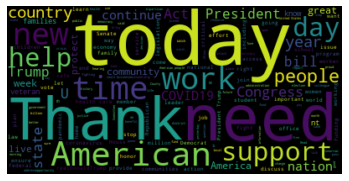

In [11]:
# Generic wordcloud

text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [24]:
rep = congress_tweets[congress_tweets['party']=='Republican']
dem = congress_tweets[congress_tweets['party']=='Democrat']
r_text = ' '.join(rep['tokens'].map(lambda text: ' '.join(text)))
d_text = ' '.join(dem['tokens'].map(lambda text: ' '.join(text)))

house = congress_tweets[congress_tweets['position']=='Rep']
sen = congress_tweets[congress_tweets['position']=='Sen']
h_text = ' '.join(house['tokens'].map(lambda text: ' '.join(text)))
s_text = ' '.join(sen['tokens'].map(lambda text: ' '.join(text)))

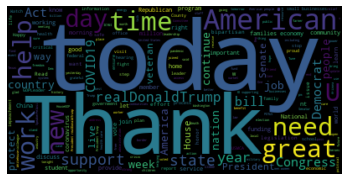

In [14]:
# Republican wordcloud

wordcloud = WordCloud().generate(r_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

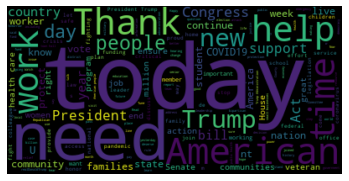

In [15]:
# Democrat wordcloud

wordcloud = WordCloud().generate(d_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**KQ**: interpretation?

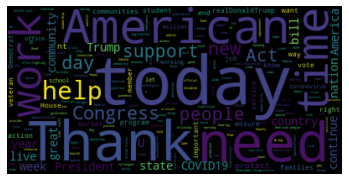

In [16]:
# House wordcloud

wordcloud = WordCloud().generate(h_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

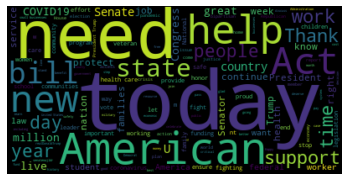

In [19]:
# Senate wordcloud

wordcloud = WordCloud().generate(s_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

The wordclouds for Republicans, Democrats, Representatives, and Senators are strikingly similar.

### Word/Character Counts

In [24]:
congress_tweets['tweet_len'] = congress_tweets['text_original'].apply(len)
congress_tweets['word_count'] = congress_tweets['text_original'].apply(lambda x: len(str(x).split()))
#congress_tweets['text'] = congress_tweets['text'].map(lambda text: ' '.join(text))
#congress_tweets['polarity'] = congress_tweets['text'].map(lambda text: TextBlob(text).sentiment.polarity)
#congress_tweets['subjectivity'] = congress_tweets['text'].map(lambda text: TextBlob(text).sentiment.subjectivi

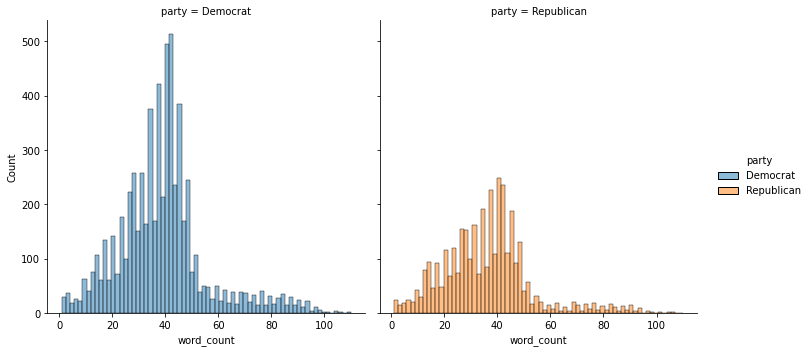

In [21]:
sns.displot(congress_tweets, x="word_count", hue = "party", col = "party")
plt.show()

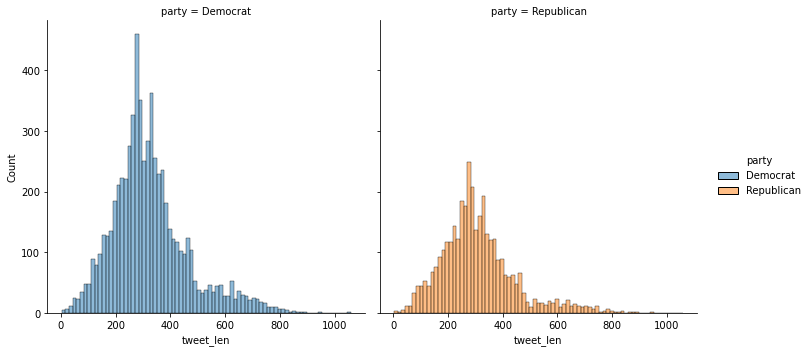

In [23]:
sns.displot(congress_tweets, x ="tweet_len", hue = "party", col = "party")
plt.show()

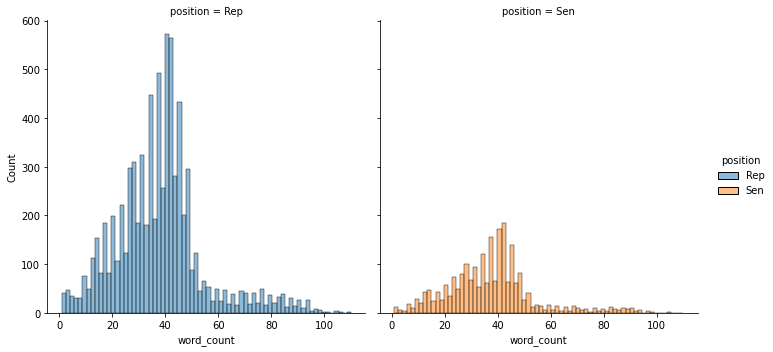

In [22]:
sns.displot(congress_tweets, x="word_count", hue = "position", col = "position")
plt.show()

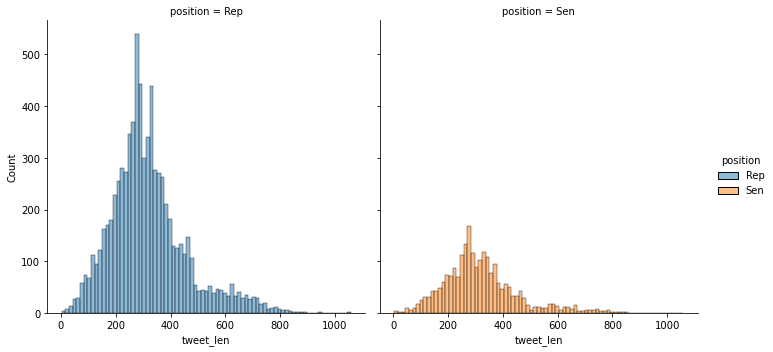

In [24]:
sns.displot(congress_tweets, x ="tweet_len", hue = "position", col = "position")
plt.show()

**KQ**: make sure to include titles for plots and explain what they tell us 

### Word Frequencies

In [19]:
y_vals = congress_tweets[['position', 'party']]
y_vals = y_vals.rename(columns={'position': 'Position', 'party':'Party'})

def make_ngram_df(ngram_range, series, y):
    bow_vector = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(ngram_range,ngram_range))
    bow_matrix = bow_vector.fit_transform(series.values.astype('U'))
    bow_matrix = bow_matrix.todense()
    bow_feature_names = bow_vector.get_feature_names()
    df = pd.DataFrame(bow_matrix, columns = bow_feature_names)
    df = pd.concat([df, y], axis=1)
    return(df)

def separate_ngram_df(df):
    df_house = df[df['Position']=='Rep']
    df_senate = df[df['Position']=='Sen']
    df_republican = df[df['Party']=='Republican']
    df_democrat = df[df['Party']=='Democrat']
    return df_house, df_senate, df_republican, df_democrat

def sort_frequencies(df):
    df = df.iloc[: , :-2]
    df = pd.DataFrame(df.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
    df = df.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
    return df

In [20]:
unigrams = make_ngram_df(1, congress_tweets['text'], y_vals)
unigrams_house, unigrams_senate, unigrams_republican, unigrams_democrat = separate_ngram_df(unigrams)
with open('unigrams.pkl', 'wb') as f:
    pickle.dump(unigrams, f)

bigrams = make_ngram_df(2, congress_tweets['text'], y_vals)
bigrams_house, bigrams_senate, bigrams_republican, bigrams_democrat = separate_ngram_df(bigrams)
with open('bigrams.pkl', 'wb') as f:
    pickle.dump(bigrams, f)

trigrams = make_ngram_df(3, congress_tweets['text'], y_vals)
trigrams_house, trigrams_senate, trigrams_republican, trigrams_democrat = separate_ngram_df(trigrams)
with open('trigrams.pkl', 'wb') as f:
    pickle.dump(trigrams, f)

/Applications/anaconda3/envs/geo/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# with open('unigrams.pkl', 'rb') as f:
#     unigrams = pickle.load(f)
    
# with open('bigrams.pkl', 'rb') as f:
#     bigrams = pickle.load(f)
    
# with open('trigrams.pkl', 'rb') as f:
#     trigrams = pickle.load(f)

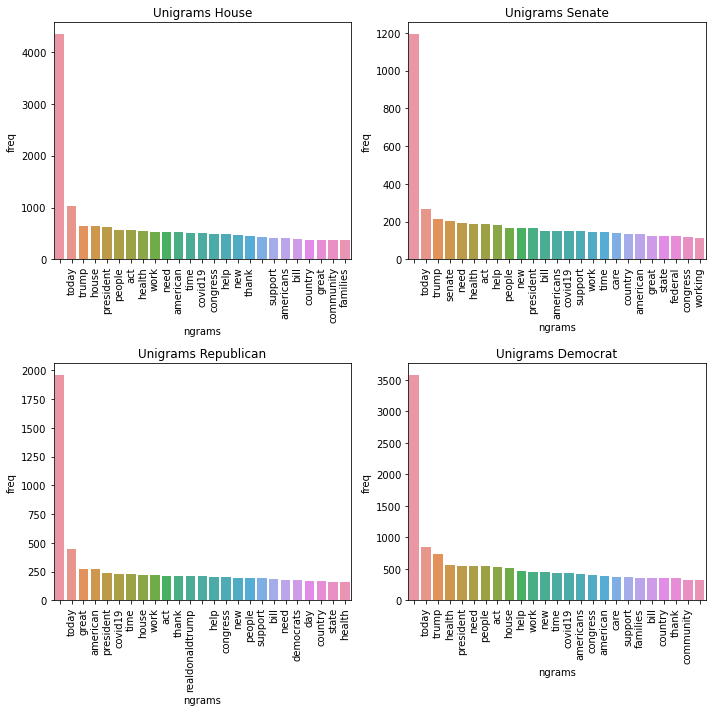

In [58]:
# Plot unigram frequencies by party and position

fig, axs = plt.subplots(2,2, figsize=(10,10))

df1 = sort_frequencies(unigrams_house)
sns.barplot(ax=axs[0,0], x='ngrams', y='freq', data = df1[0:25])
axs[0,0].set_xticklabels(labels = df1['ngrams'][0:25].tolist(),rotation=90)
axs[0,0].set_title("Unigrams House")

df2 = sort_frequencies(unigrams_senate)
sns.barplot(ax=axs[0,1], x='ngrams', y='freq', data = df2[0:25])
axs[0,1].set_xticklabels(labels = df2['ngrams'][0:25].tolist(),rotation=90)
axs[0,1].set_title("Unigrams Senate")

df3 = sort_frequencies(unigrams_republican)
sns.barplot(ax=axs[1,0], x='ngrams', y='freq', data = df3[0:25])
axs[1,0].set_xticklabels(labels = df3['ngrams'][0:25].tolist(),rotation=90)
axs[1,0].set_title("Unigrams Republican")

df4 = sort_frequencies(unigrams_democrat)
sns.barplot(ax=axs[1,1], x='ngrams', y='freq', data = df4[0:25])
axs[1,1].set_xticklabels(labels = df4['ngrams'][0:25].tolist(),rotation=90)
axs[1,1].set_title("Unigrams Democrat")

plt.tight_layout()

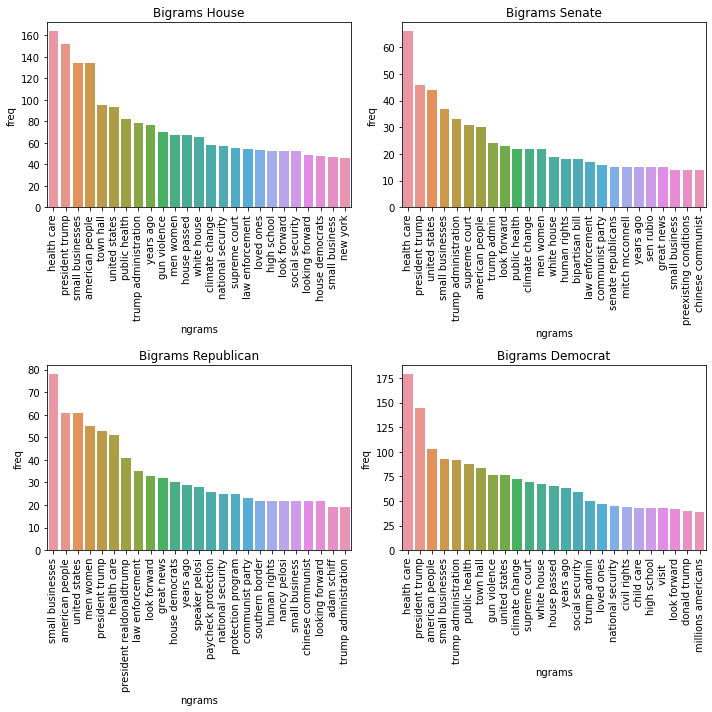

In [53]:
# Plot bigram frequencies by party and position

fig, axs = plt.subplots(2,2, figsize=(10,10))

df1 = sort_frequencies(bigrams_house)
sns.barplot(ax=axs[0,0], x='ngrams', y='freq', data = df1[0:25])
axs[0,0].set_xticklabels(labels = df1['ngrams'][0:25].tolist(),rotation=90)
axs[0,0].set_title("Bigrams House")

df2 = sort_frequencies(bigrams_senate)
sns.barplot(ax=axs[0,1], x='ngrams', y='freq', data = df2[0:25])
axs[0,1].set_xticklabels(labels = df2['ngrams'][0:25].tolist(),rotation=90)
axs[0,1].set_title("Bigrams Senate")

df3 = sort_frequencies(bigrams_republican)
sns.barplot(ax=axs[1,0], x='ngrams', y='freq', data = df3[0:25])
axs[1,0].set_xticklabels(labels = df3['ngrams'][0:25].tolist(),rotation=90)
axs[1,0].set_title("Bigrams Republican")

df4 = sort_frequencies(bigrams_democrat)
sns.barplot(ax=axs[1,1], x='ngrams', y='freq', data = df4[0:25])
axs[1,1].set_xticklabels(labels = df4['ngrams'][0:25].tolist(),rotation=90)
axs[1,1].set_title("Bigrams Democrat")

plt.tight_layout()

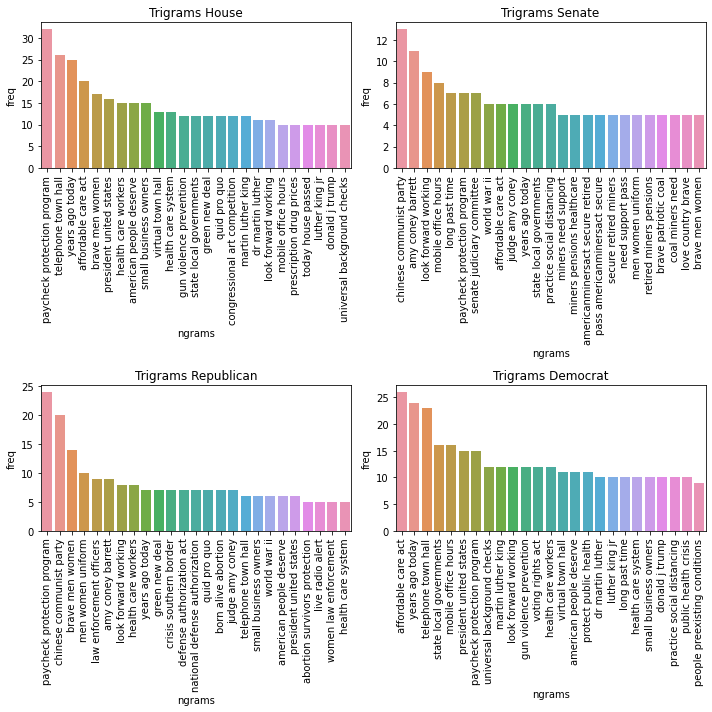

In [54]:
# Plot trigram frequencies by party and position

fig, axs = plt.subplots(2,2, figsize=(10,10))

df1 = sort_frequencies(trigrams_house)
sns.barplot(ax=axs[0,0], x='ngrams', y='freq', data = df1[0:25])
axs[0,0].set_xticklabels(labels = df1['ngrams'][0:25].tolist(),rotation=90)
axs[0,0].set_title("Trigrams House")

df2 = sort_frequencies(trigrams_senate)
sns.barplot(ax=axs[0,1], x='ngrams', y='freq', data = df2[0:25])
axs[0,1].set_xticklabels(labels = df2['ngrams'][0:25].tolist(),rotation=90)
axs[0,1].set_title("Trigrams Senate")

df3 = sort_frequencies(trigrams_republican)
sns.barplot(ax=axs[1,0], x='ngrams', y='freq', data = df3[0:25])
axs[1,0].set_xticklabels(labels = df3['ngrams'][0:25].tolist(),rotation=90)
axs[1,0].set_title("Trigrams Republican")

df4 = sort_frequencies(trigrams_democrat)
sns.barplot(ax=axs[1,1], x='ngrams', y='freq', data = df4[0:25])
axs[1,1].set_xticklabels(labels = df4['ngrams'][0:25].tolist(),rotation=90)
axs[1,1].set_title("Trigrams Democrat")

plt.tight_layout()

**KQ**: these plots are really useful and it looks like there are differences, but what do they tell us and why might that be? 

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

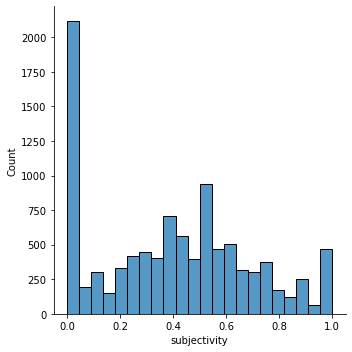

In [11]:
#checking subjectivity
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="subjectivity")
plt.show()

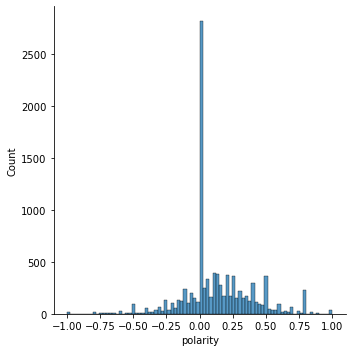

In [12]:
#checking sentiment/polarity
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets, x="polarity")
plt.show()

In [21]:
congress_tweets.head()

,Unnamed: 0,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,...,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_original,tokens,polarity,subjectivity
0,0,0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. QT ...,Val Demings,Rep,3-Jan-17,3/12/1957,...,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",Thank you for testifying today Mr. Blake. http...,"['Thank', 'testifying', 'today', 'Mr', 'Blake'...",0.000000,0.000000
1,1,1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,...,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688",My Twitter Town Hall on healthcare has begun a...,"['My', 'Twitter', 'Town', 'Hall', 'healthcare'...",0.136364,0.500000
2,2,2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,...,2,Republican,"684,872","380,494","394,409","647,744",Scipio Jones‘ fight for civil rights and equal...,"['Scipio', 'Jones', '‘', 'fight', 'civil', 'ri...",0.511111,0.833333
3,3,3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,...,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",There is no better time to #ActOnClimate than ...,"['There', 'better', 'time', 'ActOnClimate', 'E...",0.450000,0.750000
4,4,4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,understand the VA often has problems recruiti...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,...,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958",I understand the VA often has problems recruit...,"[' ', 'understand', 'VA', 'problems', 'recruit...",0.000000,0.000000


In [25]:
#republicans
rep.head()

,Unnamed: 0,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,...,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_original,tokens,polarity,subjectivity
2,2,2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,...,2,Republican,"684,872","380,494","394,409","647,744",Scipio Jones‘ fight for civil rights and equal...,"['Scipio', 'Jones', '‘', 'fight', 'civil', 'ri...",5.111111e-01,0.833333
4,4,4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,understand the VA often has problems recruiti...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,...,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958",I understand the VA often has problems recruit...,"[' ', 'understand', 'VA', 'problems', 'recruit...",0.000000e+00,0.000000
5,5,5,1.305350e+18,JohnCornyn,2020-09-13T23:23:09-04:00,RT @Johnson4Dallas This is the most accurate d...,John Cornyn,Sen,2-Dec-02,2/2/1952,...,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",RT @Johnson4Dallas This is the most accurate d...,"['Johnson4Dallas', 'This', 'accurate', 'descri...",1.850372e-17,0.405556
7,7,7,1.261460e+18,MikeKellyPA,2020-05-15T20:40:07-04:00,RT @HouseGOP The House is voting on legislatio...,Mike Kelly,Rep,3-Jan-11,5/10/1948,...,16,Republican,"2,970,733","2,926,441","2,990,274","2,680,434",RT @HouseGOP The House is voting on legislatio...,"['HouseGOP', 'The', 'House', 'voting', 'legisl...",-1.666667e-01,0.233333
9,9,9,1.308800e+18,RepSteveChabot,2020-09-23T12:02:58-04:00,"That common sense approach is needed now, more...",Steve Chabot,Rep,3-Jan-11,1/22/1953,...,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","That common sense approach is needed now, more...","['That', 'common', 'sense', 'approach', 'neede...",-1.375000e-01,0.241667


In [26]:
#choosing a republican candidate
rep_TedCruz = congress_tweets[congress_tweets["name_wikipedia"]=="Ted Cruz"].copy()
rep_TedCruz

,Unnamed: 0,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,...,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_original,tokens,polarity,subjectivity
57,57,57,1.279160e+18,SenTedCruz,2020-07-03T17:11:55-04:00,"This weekend, we celebrate the birth of our na...",Ted Cruz,Sen,3-Jan-13,12/22/1970,...,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","This weekend, we celebrate the birth of our na...","['This', 'weekend', 'celebrate', 'birth', 'nat...",0.000000,0.000000
238,238,238,1.256300e+18,SenTedCruz,2020-05-01T15:29:55-04:00,RT @EricTrump Challenge accepted @SeanHannity!...,Ted Cruz,Sen,3-Jan-13,12/22/1970,...,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",RT @EricTrump Challenge accepted @SeanHannity!...,"['EricTrump', 'Challenge', 'accepted', 'SeanHa...",0.500000,0.600000
705,705,705,1.220850e+18,SenTedCruz,2020-01-24T18:29:25-05:00,My thoughts &amp; prayers are with the familie...,Ted Cruz,Sen,3-Jan-13,12/22/1970,...,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",My thoughts &amp; prayers are with the familie...,"['My', 'thoughts', 'prayers', 'families', 'Hou...",-0.059524,0.238095
755,755,755,1.187810e+18,SenTedCruz,2019-10-25T15:26:23-04:00,It time for Congress and the American people t...,Ted Cruz,Sen,3-Jan-13,12/22/1970,...,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",It’s time for Congress and the American people...,"['It', 'time', 'Congress', 'American', 'people...",0.150000,0.225000
823,823,823,1.088950e+18,SenTedCruz,2019-01-25T18:47:06-05:00,Yesterday fought hard to immediately pay every...,Ted Cruz,Sen,3-Jan-13,12/22/1970,...,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","Yesterday, I fought hard to immediately pay ev...","['Yesterday', 'fought', 'hard', 'immediately',...",-0.090774,0.338988
1072,1072,1072,1.196490e+18,SenTedCruz,2019-11-18T13:00:00-05:00,The Trump admin should immediately revoke Iran...,Ted Cruz,Sen,3-Jan-13,12/22/1970,...,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",The Trump admin should immediately revoke Iran...,"['The', 'Trump', 'admin', 'immediately', 'revo...",0.000000,0.000000
1230,1230,1230,1.224480e+18,SenTedCruz,2020-02-03T18:56:41-05:00,RT @Astro_Mike #OTD in 1995 STS-63 launched. O...,Ted Cruz,Sen,3-Jan-13,12/22/1970,...,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",RT @Astro_Mike #OTD in 1995 STS-63 launched. O...,"['AstroMike', 'OTD', '1995', 'STS63', 'launche...",0.266667,0.300000
1428,1428,1428,1.143620e+18,SenTedCruz,2019-06-25T16:47:32-04:00,RT @dcexaminer The. froze about $100 billion i...,Ted Cruz,Sen,3-Jan-13,12/22/1970,...,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",RT @dcexaminer The U.S. froze about $100 billi...,"['dcexaminer', 'The', 'froze', '100', 'billion...",0.050000,0.050000
1542,1542,1542,1.270360e+18,SenTedCruz,2020-06-09T10:37:37-04:00,This past weekend “was the most violent weeken...,Ted Cruz,Sen,3-Jan-13,12/22/1970,...,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",This past weekend “was the most violent weeken...,"['This', 'past', 'weekend', '“', 'violent', 'w...",-0.483333,0.700000
1681,1681,1681,1.146130e+18,SenTedCruz,2019-07-02T14:43:47-04:00,Cruz Asks DHS to Create Process for Collecting...,Ted Cruz,Sen,3-Jan-13,12/22/1970,...,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",Cruz Asks DHS to Create Process for Collecting...,"['Cruz', 'Asks', 'DHS', 'Create', 'Process', '...",0.000000,0.000000


In [27]:
#Ted Cruz subjectivity
rep_TedCruz_mean = rep_TedCruz["subjectivity"].mean()
print(rep_TedCruz_mean)

0.34564626422959766


In [30]:
#Ted Cruz polarity
rep_TedCruz_mean2 = rep_TedCruz["polarity"].mean()
print(rep_TedCruz_mean2)

0.08605577601410934


In [31]:
#democrat
dem.head()

,Unnamed: 0,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,...,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_original,tokens,polarity,subjectivity
0,0,0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. QT ...,Val Demings,Rep,3-Jan-17,3/12/1957,...,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",Thank you for testifying today Mr. Blake. http...,"['Thank', 'testifying', 'today', 'Mr', 'Blake'...",0.000000,0.000000
1,1,1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,...,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688",My Twitter Town Hall on healthcare has begun a...,"['My', 'Twitter', 'Town', 'Hall', 'healthcare'...",0.136364,0.500000
3,3,3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,...,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",There is no better time to #ActOnClimate than ...,"['There', 'better', 'time', 'ActOnClimate', 'E...",0.450000,0.750000
6,6,6,1.302610e+18,RepTimRyan,2020-09-06T10:09:00-04:00,"Instead of solving the problem with us, the Pr...",Tim Ryan,Rep,3-Jan-03,7/16/1973,...,13,Democrat,"2,841,005","2,394,164","2,827,709","2,661,437","Instead of solving the problem with us, the Pr...","['Instead', 'solving', 'problem', 'President',...",0.136364,0.454545
8,8,8,1.105550e+18,RepDonBeyer,2019-03-12T15:17:24-04:00,"If this is what he calls ""winning"" then yes am...",Don Beyer,Rep,3-Jan-15,6/20/1950,...,8,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","If this is what he calls ""winning"" then yes, I...","['If', 'calls', 'winning', 'yes', 'tired', ' '...",0.044444,0.505556


In [32]:
#choosing democrat candidate
dem_JoshHarder = congress_tweets[congress_tweets["name_wikipedia"]=="Josh Harder"].copy()
dem_JoshHarder

,Unnamed: 0,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,...,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_original,tokens,polarity,subjectivity
116,116,116,1.174500e+18,RepJoshHarder,2019-09-18T21:45:00-04:00,Great to meet with students enrolled in Patter...,Josh Harder,Rep,3-Jan-19,8/1/1986,...,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Great to meet with students enrolled in Patter...,"['Great', 'meet', 'students', 'enrolled', 'Pat...",0.311429,0.481429
653,653,653,1.109260e+18,RepJoshHarder,2019-03-22T21:00:00-04:00,Thanks Kathy. Still have lots of work to do.,Josh Harder,Rep,3-Jan-19,8/1/1986,...,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Thanks Kathy. Still have lots of work to do. h...,"['Thanks', 'Kathy', 'Still', 'lots', 'work']",0.200000,0.200000
680,680,680,1.133890e+18,RepJoshHarder,2019-05-29T20:15:00-04:00,This Memorial Day attended three powerful even...,Josh Harder,Rep,3-Jan-19,8/1/1986,...,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",This Memorial Day I attended three powerful ev...,"['This', 'Memorial', 'Day', 'attended', 'power...",0.150000,0.625000
722,722,722,1.163620e+18,RepJoshHarder,2019-08-19T21:00:00-04:00,As housing prices skyrocket in the Valley far ...,Josh Harder,Rep,3-Jan-19,8/1/1986,...,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",As housing prices skyrocket in the Valley far ...,"['As', 'housing', 'prices', 'skyrocket', 'Vall...",0.050000,0.550000
2082,2082,2082,1.179940e+18,RepJoshHarder,2019-10-03T21:45:00-04:00,Thanks to the City Ministry Network for inviti...,Josh Harder,Rep,3-Jan-19,8/1/1986,...,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Thanks to the City Ministry Network for inviti...,"['Thanks', 'City', 'Ministry', 'Network', 'inv...",0.409091,0.487500
2099,2099,2099,1.116720e+18,RepJoshHarder,2019-04-12T11:14:11-04:00,Correct. QT @nowthisnews Betsy DeVos plans to...,Josh Harder,Rep,3-Jan-19,8/1/1986,...,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Correct. https://twitter.com/nowthisnews/statu...,"['Correct', ' ', 'nowthisnews', 'Betsy', 'DeVo...",0.000000,0.000000
2374,2374,2374,1.104130e+18,RepJoshHarder,2019-03-08T16:30:01-05:00,We did it!,Josh Harder,Rep,3-Jan-19,8/1/1986,...,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",We did it! http://pbs.twimg.com/ext_tw_video_t...,"['We', ' ']",0.000000,0.000000
2788,2788,2788,1.241120e+18,RepJoshHarder,2020-03-20T18:03:38-04:00,.Isolation masks.Hand sanitizer – 60% and grea...,Josh Harder,Rep,3-Jan-19,8/1/1986,...,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",1.Isolation masks\n2.Hand sanitizer – 60% and ...,"['Isolation', 'masksHand', 'sanitizer', '–', '...",0.238095,0.309524
2789,2789,2789,1.275130e+18,RepJoshHarder,2020-06-22T14:00:00-04:00,Coronavirus hospitalizations in California hi...,Josh Harder,Rep,3-Jan-19,8/1/1986,...,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",🚨 Coronavirus hospitalizations in California h...,"[' ', 'Coronavirus', 'hospitalizations', 'Cali...",0.253333,0.680000
2844,2844,2844,1.215760e+18,RepJoshHarder,2020-01-10T17:02:26-05:00,Every day wake up appreciate the trust that pe...,Josh Harder,Rep,3-Jan-19,8/1/1986,...,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","Every day I wake up, I appreciate the trust th...","['Every', 'day', 'wake', 'appreciate', 'trust'...",0.600000,0.875000


In [33]:
#Josh Harder subjectivity
dem_JoshHarder_mean = dem_JoshHarder["subjectivity"].mean()
print(dem_JoshHarder_mean)

0.3314043140767279


In [34]:
#Josh Harder polarity
dem_JoshHarder_mean2 = dem_JoshHarder["polarity"].mean()
print(dem_JoshHarder_mean2)

0.1076481564412599


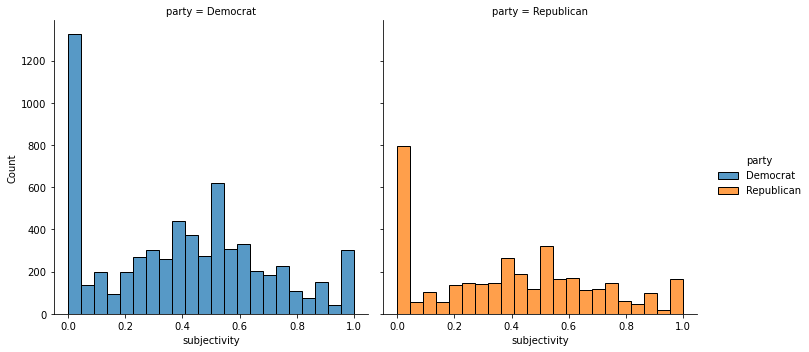

In [35]:
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

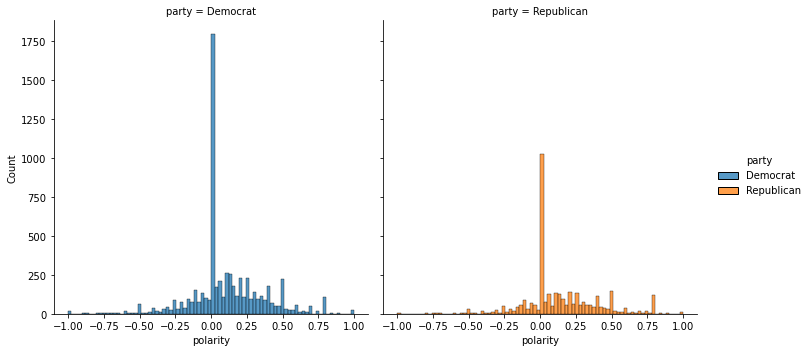

In [36]:
sns.displot(congress_tweets, x="polarity", hue = "party", col = "party")
plt.show()

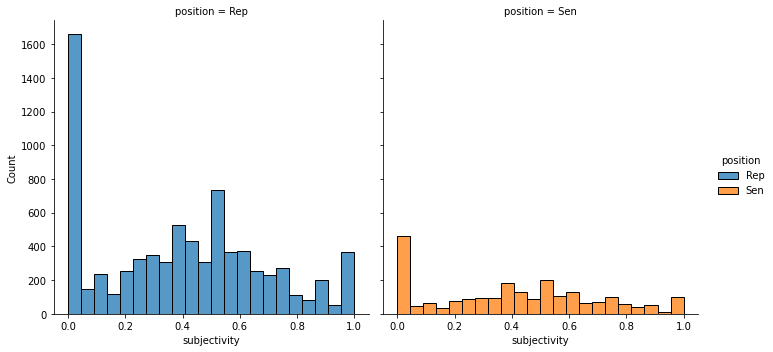

In [37]:
sns.displot(congress_tweets, x="subjectivity", hue = 'position', col = 'position')
plt.show()

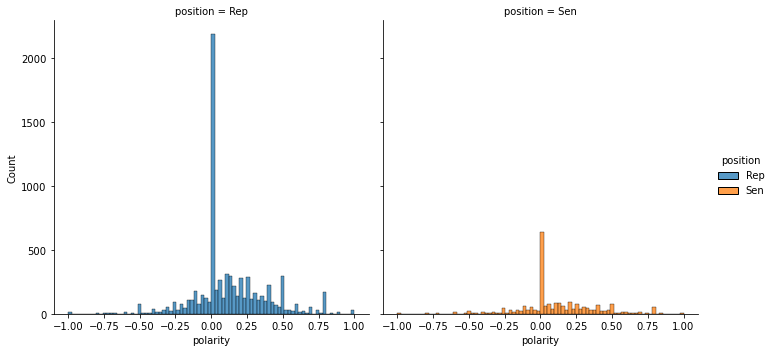

In [38]:
sns.displot(congress_tweets, x="polarity", hue = 'position', col = 'position')
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [25]:
# Engineered Features
engineered_features = congress_tweets[['polarity', 'subjectivity','tweet_len', 'word_count']].reset_index(drop = True)

# # Topic Model + Engineered Features
# engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

# engineered_features_with_topics.head() 

### Word Frequencies: BOW and TFIDF

In [60]:
# BOW dataframes for unigrams (top_25_unigrams), bigrams (top_25_bigrams), trigrams (top_25_trigrams)

dictionary_dataframe = unigrams.iloc[: , :-2]
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
top_25_unigrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]

dictionary_dataframe = bigrams.iloc[: , :-2]
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
top_25_bigrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]

dictionary_dataframe = trigrams.iloc[: , :-2]
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
top_25_trigrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]

In [61]:
# Tfidf dataframe (topic_dist_df)

tfidf_vector = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix = tfidf_vector.fit_transform(congress_tweets['text'])
tfidf_matrix = tfidf_matrix.todense()
tfidf_feature_names = tfidf_vector.get_feature_names()

lda = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=0)
lda = lda.fit(tfidf_matrix)

topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

/Applications/anaconda3/envs/geo/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Applications/anaconda3/envs/geo/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/Applications/anaconda3/envs/geo/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [62]:
topic_dist_df

,0,1,2,3,4,5,6,7,8,9
0,0.142313,0.019148,0.019150,0.019148,0.019148,0.019148,0.019148,0.704504,0.019148,0.019148
1,0.022821,0.022821,0.022821,0.117970,0.022821,0.022821,0.022821,0.699455,0.022821,0.022827
2,0.017788,0.017786,0.017786,0.183768,0.017787,0.017786,0.017786,0.673939,0.017787,0.017786
3,0.023590,0.023590,0.023593,0.205256,0.023590,0.023591,0.023590,0.606003,0.023595,0.023601
4,0.020700,0.020700,0.020700,0.020700,0.020700,0.020700,0.020700,0.813696,0.020700,0.020700
...,...,...,...,...,...,...,...,...,...,...
9995,0.017961,0.017975,0.170928,0.017961,0.017960,0.017961,0.017960,0.685376,0.017960,0.017960
9996,0.022925,0.022926,0.397172,0.022925,0.022925,0.022925,0.022927,0.419424,0.022925,0.022925
9997,0.241362,0.022644,0.022643,0.022643,0.022642,0.022643,0.022644,0.577495,0.022643,0.022643
9998,0.022784,0.108580,0.022784,0.022784,0.109680,0.022784,0.022784,0.622251,0.022787,0.022784


### Word Embedding

In [19]:
model = gensim.models.Word2Vec(congress_tweets['tokens'], vector_size=100, window=5, 
                               min_count=5, sg=0, alpha=0.025, epochs=5, batch_words=10000)

In [20]:
words = list(model.wv.key_to_index)
print(words[0:100])

[' ', '\n\n', 'The', 'We', 'Trump', 'This', 'It', 'today', 'House', 'people', 'need', 'President', 'COVID19', 'work', 'help', 'American', 'Act', 'time', 'health', 'Congress', 'Americans', 'Today', 'support', '“', 'country', 'bill', 'families', '  ', 'care', 'Senate', 'Thank', 'continue', 'community', 'week', 'America', 'like', 'workers', 'new', 'protect', 'nation', 'working', 'federal', 'communities', 'realDonaldTrump', 'day', 'years', 'women', '\n ', 'vote', 'As', 'crisis', '–', 'If', 'public', 'state', 'important', 'year', 'great', 'legislation', 'right', 'bipartisan', 'funding', 'In', 'law', 'know', 'ensure', 'businesses', 'pandemic', '\n \n', 'Our', 'Democrats', 'safe', 'students', 'proud', 'fight', 'lives', 'economy', 'coronavirus', 'passed', 'family', 'My', 'home', 'office', 'That', 'million', 'government', 'small', 'local', 'colleagues', 'honor', 'discuss', 'pass', 'relief', 'access', 'jobs', 'end', 'way', 'New', '’', 'critical']


In [21]:
# embedding based featurization
len(congress_tweets['tokens'][0])

21

In [23]:
doc = [word for word in congress_tweets['tokens'][0] if word in model.wv.key_to_index]
len(doc)

18

In [25]:
first_vec = []
for token in model.wv.__getitem__(doc):
    first_vec.append(token[0])
numpy.mean(first_vec)

-0.22697909

In [26]:
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.vocab]
    return numpy.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [ ]:
# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
for puppy in congress_tweets['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, puppy))
    
doc_average_embeddings = numpy.array(empty_list_embeddings_means) # list to array

In [ ]:
doc_average_embeddings

In [ ]:
doc_average_embeddings.shape

**KQ**: ^ what's going on here? why didn't this run? 

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [26]:
#binarizing label for party and position
lb_style = LabelBinarizer()
y_party = congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets["party"])
y_position = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])

# create model
logit_reg = LogisticRegression()

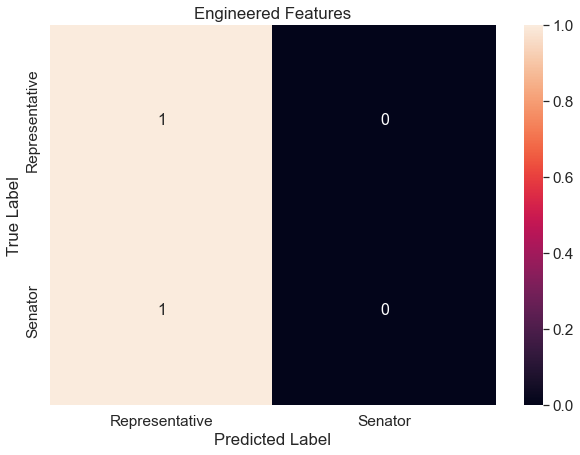

In [28]:
# Engineered Features - Position

dataframe = engineered_features
title = 'Engineered Features'
y = y_position
col_0 = "Representative"
col_1 = "Senator"

# train/test split
X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

# run prediction
y_pred = logit_model.predict(X_test)

# create confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),range(2))
df_cm = df_cm.rename(index=str, columns={0: col_0, 1: col_1})
df_cm.index = [col_0, col_1]

# plot confusion mat
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title(title)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


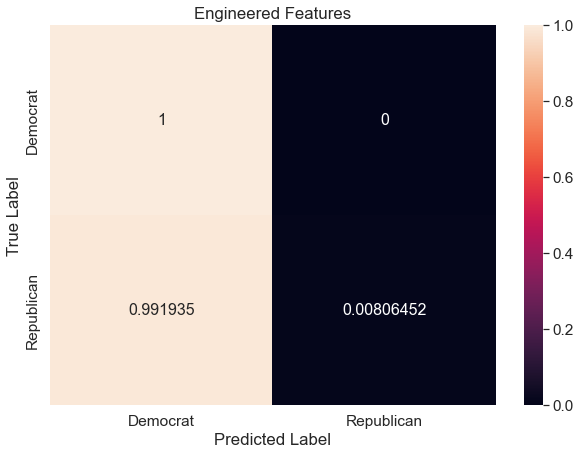

In [30]:
# Engineered Features - Party

dataframe = engineered_features
title = 'Engineered Features'
y = y_party
col_0 = "Democrat"
col_1 = "Republican"

# train/test split
X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

# run prediction
y_pred = logit_model.predict(X_test)

# create confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),range(2))
df_cm = df_cm.rename(index=str, columns={0: col_0, 1: col_1})
df_cm.index = [col_0, col_1]

# plot confusion matrix
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title(title)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

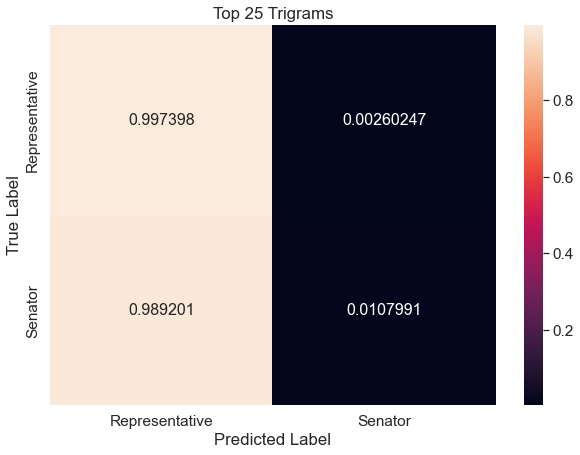

In [64]:
# BOW - Position

dataframe = top_25_trigrams
title = 'Top 25 Trigrams'
y = y_position
col_0 = "Representative"
col_1 = "Senator"

# train/test split
X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

# run prediction
y_pred = logit_model.predict(X_test)

# create confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),range(2))
df_cm = df_cm.rename(index=str, columns={0: col_0, 1: col_1})
df_cm.index = [col_0, col_1]

# plot confusion matrix
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title(title)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

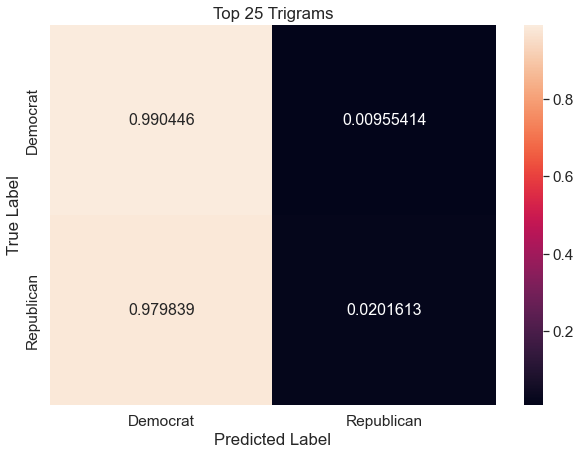

In [63]:
# BOW - Party

dataframe = top_25_trigrams
title = "Top 25 Trigrams"
y = y_party
col_0 = "Democrat"
col_1 = "Republican"

# train/test split
X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

# run prediction
y_pred = logit_model.predict(X_test)

# create confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),range(2))
df_cm = df_cm.rename(index=str, columns={0: col_0, 1: col_1})
df_cm.index = [col_0, col_1]

# plot confusion matrix
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title(title)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

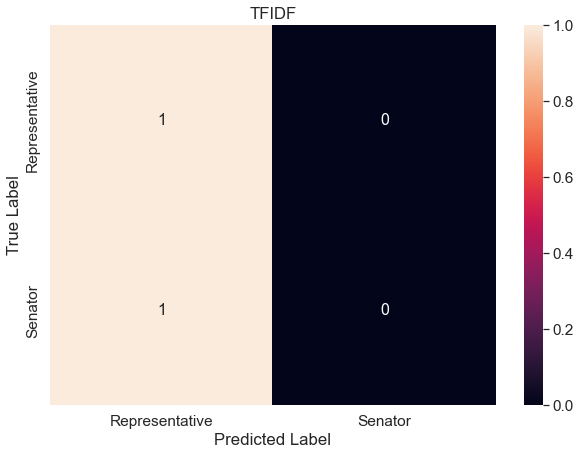

In [66]:
# TFIDF - Position

dataframe = topic_dist_df
title = "TFIDF"
y = y_position
col_0 = "Representative"
col_1 = "Senator"

# train/test split
X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

# run prediction
y_pred = logit_model.predict(X_test)

# create confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),range(2))
df_cm = df_cm.rename(index=str, columns={0: col_0, 1: col_1})
df_cm.index = [col_0, col_1]

# plot confusion matrix
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title(title)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

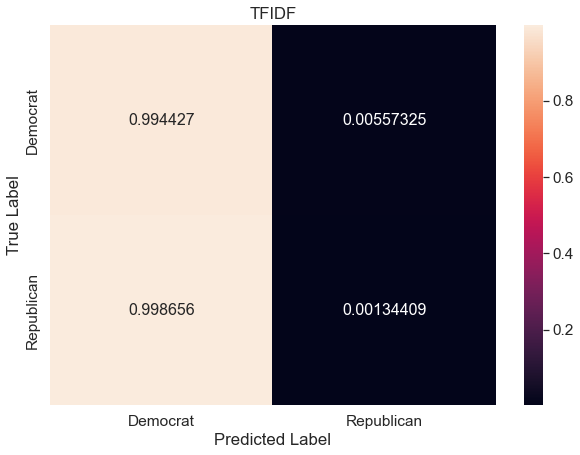

In [67]:
# TFIDF: Party

dataframe = topic_dist_df
title = "TFIDF"
y = y_party
col_0 = "Democrat"
col_1 = "Republican"

# train/test split
X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

# run prediction
y_pred = logit_model.predict(X_test)

# create confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),range(2))
df_cm = df_cm.rename(index=str, columns={0: col_0, 1: col_1})
df_cm.index = [col_0, col_1]

# plot confusion matrix
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title(title)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [32]:
# Word embeddings - Party

# train/test split
train, test = train_test_split(congress_tweets, test_size=0.2, random_state=42)

#associate each document with the class that we want to predict later
ct_train_tagged = train.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.party_binary]), axis=1)
ct_test_tagged = test.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.party_binary]), axis=1)

In [42]:
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores - 1)
model_dbow.build_vocab([x for x in tqdm(ct_train_tagged.values)])

100%|██████████| 8000/8000 [00:00<00:00, 43036.05it/s]


In [44]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(ct_train_tagged.values)]), 
                     total_examples=len(ct_train_tagged.values), epochs=30)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 8000/8000 [00:00<00:00, 1576583.75it/s]


In [47]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

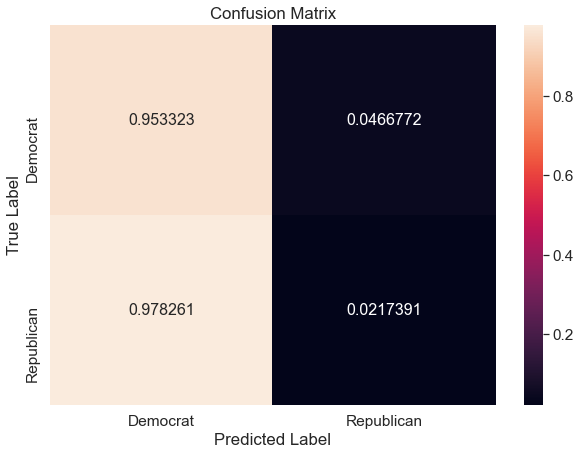

In [48]:
y_train, X_train = vec_for_learning(model_dbow, ct_train_tagged)
y_test, X_test = vec_for_learning(model_dbow, ct_test_tagged)
logit_reg = LogisticRegression()
logit_model = logit_reg.fit(X_train, y_train)
y_pred = logit_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Word Embeddings')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [33]:
# Word Embeddings - Position

#associate each document with the class that we want to predict later
ct_train_tagged = train.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.position_binary]), axis=1)
ct_test_tagged = test.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.position_binary]), axis=1)

In [34]:
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores - 1)
model_dbow.build_vocab([x for x in tqdm(ct_train_tagged.values)])

100%|██████████████████████████████████| 8000/8000 [00:00<00:00, 1308267.00it/s]


In [35]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(ct_train_tagged.values)]), 
                     total_examples=len(ct_train_tagged.values), epochs=30)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████| 8000/8000 [00:00<00:00, 2151063.02it/s]


In [65]:
#binarizing label for position
y = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])
train, test = train_test_split(congress_tweets, test_size=0.2, random_state=42)

#associate each document with the class (position) that we want to predict later
ct_train_tagged = train.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.position_binary]), axis=1)
ct_test_tagged = test.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.position_binary]), axis=1)

y_train, X_train = vec_for_learning(model_dbow, ct_train_tagged)
y_test, X_test = vec_for_learning(model_dbow, ct_test_tagged)
logit_reg = LogisticRegression()
logit_model = logit_reg.fit(X_train, y_train)
y_pred = logit_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
df_cm.index = ["Representative", "Senator"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm,
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

TypeError: Parameter doc_words of infer_vector() must be a list of strings (not a single string).

**KQ**: ?? 

### Two Combined Models

Although all models (with sentiment scores, n-grams, tf-idf and word embeddings) performed pretty poorly at predicting republican members of congress and senators (as opposed to democrats and representatives), the models based on top-25 trigrams are better than others at capturing a very small percentage of republicans and senators  (2% and 1% respectively) while still performing with above 95% and 99%  accuracy respectively for democrats and representatives. That’s why we include the 25 trigrams in the combined models below as the text feature.

In [58]:
# Non-text features
congress_tweets['gender_binary'] = lb_style.fit_transform(congress_tweets["gender"])
congress_tweets['trump_2016_state_share'] = congress_tweets['trump_2016_state_share'].replace(',','', regex=True).astype(float)
congress_tweets['clinton_2016_state_share'] = congress_tweets['clinton_2016_state_share'].replace(',','', regex=True).astype(float)
congress_tweets['trump_clinton_ratio'] = congress_tweets['trump_2016_state_share']/congress_tweets['clinton_2016_state_share']
non_text = congress_tweets[['gender_binary', 'trump_clinton_ratio']]


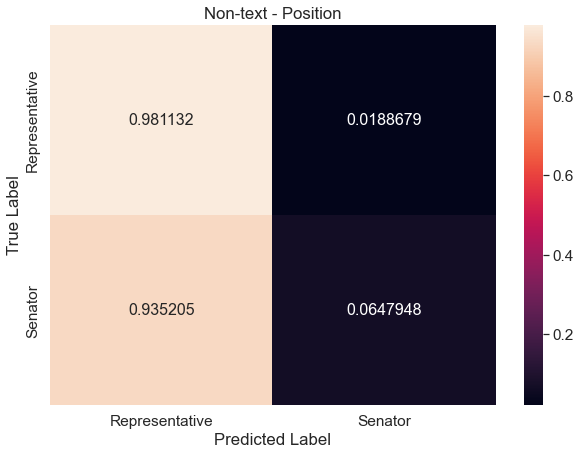

In [59]:
# Non-text position

dataframe = non_text
title = "Non-text - Position"
y = y_position
col_0 = "Representative"
col_1 = "Senator"

# train/test split
X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

# run prediction
y_pred = logit_model.predict(X_test)

# create confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),range(2))
df_cm = df_cm.rename(index=str, columns={0: col_0, 1: col_1})
df_cm.index = [col_0, col_1]

# plot confusion matrix
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title(title)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

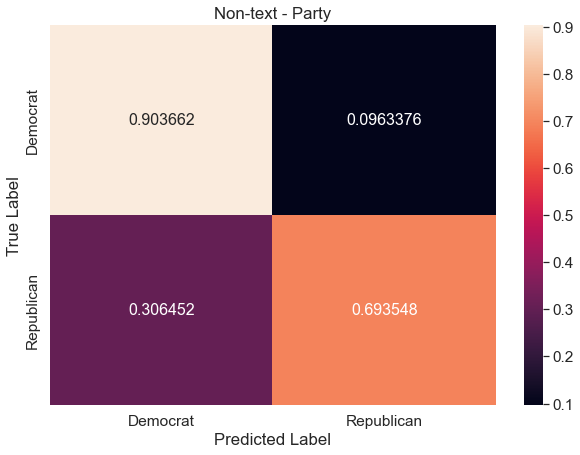

In [60]:
# Non-text party

dataframe = non_text
title = "Non-text - Party"
y = y_party
col_0 = "Democrat"
col_1 = "Republican"

# train/test split
X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

# run prediction
y_pred = logit_model.predict(X_test)

# create confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),range(2))
df_cm = df_cm.rename(index=str, columns={0: col_0, 1: col_1})
df_cm.index = [col_0, col_1]

# plot confusion matrix
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title(title)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [61]:
# Combining non-text features with best text features
best_text = top_25_trigrams.copy()
best_text_non_text = non_text.join(best_text)

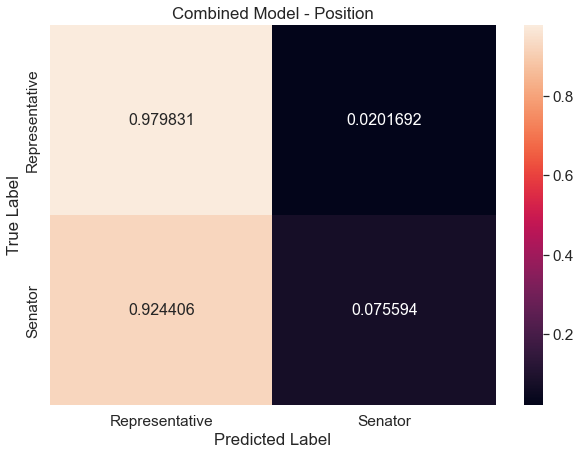

In [62]:
# Combined model position

dataframe = best_text_non_text
title = "Combined Model - Position"
y = y_position
col_0 = "Representative"
col_1 = "Senator"

# train/test split
X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

# run prediction
y_pred = logit_model.predict(X_test)

# create confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),range(2))
df_cm = df_cm.rename(index=str, columns={0: col_0, 1: col_1})
df_cm.index = [col_0, col_1]

# plot confusion matrix
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title(title)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

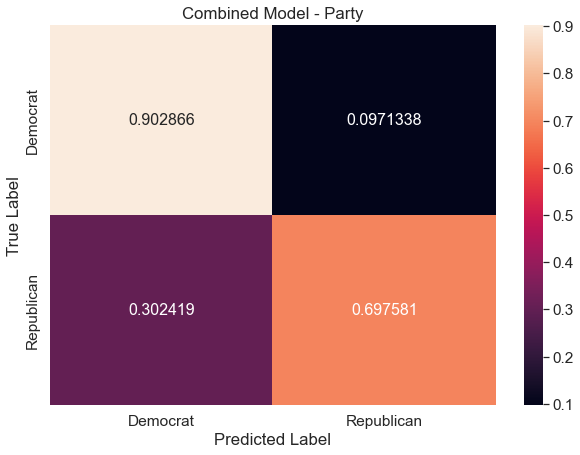

In [63]:
# Combined model party

dataframe = best_text_non_text
title = "Combined Model - Party"
y = y_party
col_0 = "Democrat"
col_1 = "Republican"

# train/test split
X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

# run prediction
y_pred = logit_model.predict(X_test)

# create confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),range(2))
df_cm = df_cm.rename(index=str, columns={0: col_0, 1: col_1})
df_cm.index = [col_0, col_1]

# plot confusion matrix
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title(title)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [64]:
# dictionary_dataframe = trigrams.iloc[: , :-2]
# df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
# df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
# top_25_trigrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]

# with open('top_25_trigrams.pkl', 'wb') as f:
#     pickle.dump(top_25_trigrams, f)

# with open('model_dbow.pkl', 'wb') as f:
#     pickle.dump(model_dbow, f)



## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

There are certain frequent words or characters that are part of the data, depending on where it's coming from. In this case, we found that twitter data included specific terms such as "rt" or "http" as well as unique letters that appear frequently yet do not provide any meaningful information about the content of tweets, potentially leading to a distorted analysis and classification. In our case, we also had to remove additional punctuation that appeared during topic modeling and other parts of exploratory data analysis that we iteratively incorporated into preprocessing.

**KQ**: nice job going back and tuning the rempuncstop function based on what you saw in the wordcloud to remove noise

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

Both Republicans and Democrats showed the same overall trends in subjectivity and polarity. Their distributions looked similar in terms of subjectivity, with the counts just being a bit higher for Democrats across the board. What we see in the graphs is that the data generally followers a normal distribution but there is a huge peak (that would definitely skew the mean) on the side of having a 0.0 score on subjectivity mean that many of the tweets on a bipartisan level use more emotion/personal judgment compared to factual information. For polarity, again, both. distributions look similar but the counts are just higher for Democrats. These graphs are slightly left skewed (meaning that tweets do seem to be a bit more positive than negative) with a very large peak in the middle at 0.0. Our model tended to show that a large number of the tweets were of neutral (not positive or negative) sentiment.

For Senators and Representatives, we see similar trends to what we saw at the partisan level. Both graphs or groups show the same trends and distributions with the Representatives having much higher counts (because there are more Representatives than Senators). In both the case of subjectivity, we see that the distribution seems to vaguely mirror a normal one with a little bit of flatness, but there is a large peak again at the 0.0 level for subjectivity. This means that a large number of the tweets are emotional/based on personal judgment instead of fact. For polarity, the distribution is also a bit left skewed meaning there is a tendency towards positive tweets, but there is a very large peak again at the 0.0 position indicating a large number of neutral (not positive/negative tweets).

**KQ**: don't forget about what we saw in class around the polarity and subjectivity, how only certain words are flagged and this might be a function of library idiosyncracies. Nice job on this question overall though

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

In this case, the purpose of exploratory analysis and unsupervised learning approaches is to have an idea of distinguishing words/topics/sentiments for the classification task of identifying democrat vs. republicans as well as representatives vs. senators. 

In order to understand whether different unsupervised learning techniques help with this task, we have to train and test models including features that are created during exploratory analysis on a subset of our data, and then validate the predictive power of our trained model on out-of-sample subset of the data. Unless the trained model is validated on out-of-sample validation set, we risk overfitting.

**KQ**: yes, this sounds right. You might have also talked about how EDA are useful for visualiation but it's good to validate that what patterns we spot by eye are true differences statistically

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

The non-text features that we chose (gender, ratio of trump to clinton) performed significantly better than the text figures alone. The combined text and non-text performed marginally better than non-text alone. The intuition behind including non-text features, in this case, is that they can be quite powerful. It stands to reason that the ratio of trump to clinton votes would do a good job predicting party, for example.

**KQ**: see comments throughout. Overall, you lost points because there aren't interpretations or explanations for what the various featurization techniques were doing, the EDA output, and made sure all the code runs. I didn't take off points for this but hyperparameter tuning would have made your models perform much better, which is one of the major benefits of ML that we covered extensively last semester. 